# Generating useful features for further analysis on Amazon reviews

## Introduction

**Business Context.** You are a business consultant with new clients that are interested in analyzing reviews of their products on Amazon (as opposed to Yelp). They want to answer business questions like: "What are the most important factors driving negative reviews?", "Have there been any large changes to customer satisfaction/reviews over time?", etc.

**Business Problem.** Your main task is to **explore the given data and use the results of your investigation to engineer relevant features that could facilitate subsequent analysis and model-building**.

**Analytical Context.** The dataset provided is a large body of reviews related to movies and television left on Amazon between 1996 and 2014. When exploring our dataset, we will quickly encounter a familiar problem we discussed in the previous case: the word "good" is one of the most important words in both positive *and* negative reviews. Thus, we must develop methods to put "good" in the appropriate context.

## Loading the data

We use a dataset of around 37,000 video reviews from Amazon Instant Video and 1,700,000 movie and TV reviews, all obtained from the website: http://jmcauley.ucsd.edu/data/amazon/. Note that there are much larger datasets available at the same site. We can expect better and more consistent results on larger datasets (such as book reviews). Note that these datasets are compressed (gzipped), and they are in [JSON](https://en.wikipedia.org/wiki/JSON) format, with each line representing a review and each line being its own JSON object.

We begin by loading the dataset below:

In [1]:
%matplotlib inline

In [2]:
%%time
import gzip
import json
import string

import nltk # imports the natural language toolkit
import pandas as pd
import plotly
import matplotlib.pyplot as plt

nltk.download('punkt')


# we can tell pandas that our file is in gzip format and it will handle the decompression for us
# we also use `lines=True` to indicate that each line of the file is its own JSON object
instant_video = pd.read_json("reviews_Amazon_Instant_Video_5.json.gz", lines=True, compression='gzip')


# ----------
# The Movies and TV file is very big. If you have problems loading it, you can load only the first 
# 10000 reviews by using 'chunksize'. All of the analysis can be 
# done in the same way using only the subset of reviews but some of the results might be different from the examples.
# ----------
movies_tv = next(pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip', chunksize=10000))
# If your computer has enough memory, uncomment the line below to use the entire dataset.
# movies_tv = pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip')


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


CPU times: user 1.96 s, sys: 794 ms, total: 2.76 s
Wall time: 11.8 s


## Examining the data

We take a look at the first 5 rows of each dataset to see what attributes are available. These are

* **reviewerID:** A unique ID to identify the author of the review.
* **asin:** The ["Amazon Standard Identification Number"](https://www.amazon.com/gp/seller/asin-upc-isbn-info.html) which provides more information about the exact product and version.
* **reviewerName:** The username chosen by the reviewer.
* **helpful:** A record of how many users indicated that the review was helpful/not helpful.
* **reviewText:** The full text of the review.
* **overall:** The overall rating (1-5) left by the reviewer.
* **summary:** A short version of the review, used as the title.
* **unixReviewTime:** The date that the review was created, in [Unix Epoch](https://en.wikipedia.org/wiki/Unix_time) format.
* **reviewTime:** A human readable date giving the day, month, and year.
</font>

In [3]:
print(len(instant_video))
print(instant_video.head(5))

37126
       reviewerID        asin                    reviewerName helpful  \
0  A11N155CW1UV02  B000H00VBQ                        AdrianaM  [0, 0]   
1  A3BC8O2KCL29V2  B000H00VBQ                         Carol T  [0, 0]   
2   A60D5HQFOTSOM  B000H00VBQ  Daniel Cooper "dancoopermedia"  [0, 1]   
3  A1RJPIGRSNX4PW  B000H00VBQ                  J. Kaplan "JJ"  [0, 0]   
4  A16XRPF40679KG  B000H00VBQ                   Michael Dobey  [1, 1]   

                                          reviewText  overall  \
0  I had big expectations because I love English ...        2   
1  I highly recommend this series. It is a must f...        5   
2  This one is a real snoozer. Don't believe anyt...        1   
3  Mysteries are interesting.  The tension betwee...        4   
4  This show always is excellent, as far as briti...        5   

                          summary  unixReviewTime   reviewTime  
0      A little bit boring for me      1399075200   05 3, 2014  
1           Excellent Grown Up TV 

In [4]:
print(len(movies_tv))
print(movies_tv.head(5))

10000
       reviewerID        asin                         reviewerName helpful  \
0   ADZPIG9QOCDG5  0005019281  Alice L. Larson "alice-loves-books"  [0, 0]   
1  A35947ZP82G7JH  0005019281                        Amarah Strack  [0, 0]   
2  A3UORV8A9D5L2E  0005019281                      Amazon Customer  [0, 0]   
3  A1VKW06X1O2X7V  0005019281           Amazon Customer "Softmill"  [0, 0]   
4  A3R27T4HADWFFJ  0005019281                                 BABE  [0, 0]   

                                          reviewText  overall  \
0  This is a charming version of the classic Dick...        4   
1  It was good but not as emotionally moving as t...        3   
2  Don't get me wrong, Winkler is a wonderful cha...        3   
3  Henry Winkler is very good in this twist on th...        5   
4  This is one of the best Scrooge movies out.  H...        4   

                                        summary  unixReviewTime   reviewTime  
0                     good version of a classic      12

We notice that `movies_tv` is extremely long with nearly 2 million reviews, and several columns seem uninteresting or hard to work with (e.g. `reviewerID`, `asin`, `reviewername`, `reviewtime`). We drop some information to make some of our later analysis more efficient. We also add a datetime column with Python datetime objects to more easily summarize the data:

In [5]:
%%time
movies_tv['datetime'] = pd.to_datetime(movies_tv['reviewTime'], format="%m %d, %Y")
instant_video['datetime'] = pd.to_datetime(instant_video['reviewTime'], format="%m %d, %Y")

CPU times: user 120 ms, sys: 2.56 ms, total: 122 ms
Wall time: 506 ms


In [6]:
movies_tv = movies_tv.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])
instant_video = instant_video.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])

movies_tv.head(5)

,helpful,reviewText,overall,summary,unixReviewTime,datetime
0,"[0, 0]",This is a charming version of the classic Dick...,4,good version of a classic,1203984000,2008-02-26
1,"[0, 0]",It was good but not as emotionally moving as t...,3,Good but not as moving,1388361600,2013-12-30
2,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3,Winkler's Performance was ok at best!,1388361600,2013-12-30
3,"[0, 0]",Henry Winkler is very good in this twist on th...,5,It's an enjoyable twist on the classic story,1202860800,2008-02-13
4,"[0, 0]",This is one of the best Scrooge movies out. H...,4,Best Scrooge yet,1387670400,2013-12-22


### Exercise 1:

#### 1.1

Plot histograms of all numeric quantities. Do you notice anything interesting about them?

**Answer.**

1. For the `instant_video` dataset:

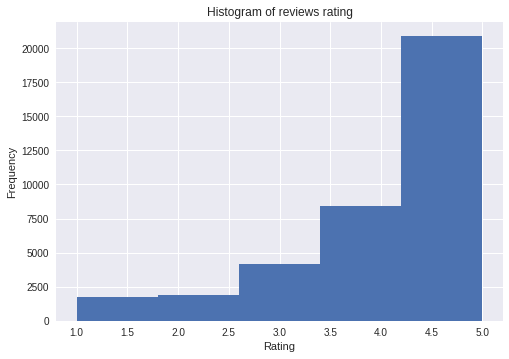

In [7]:
plt.style.use('seaborn')
plt.hist(instant_video['overall'],bins=5)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of reviews rating');

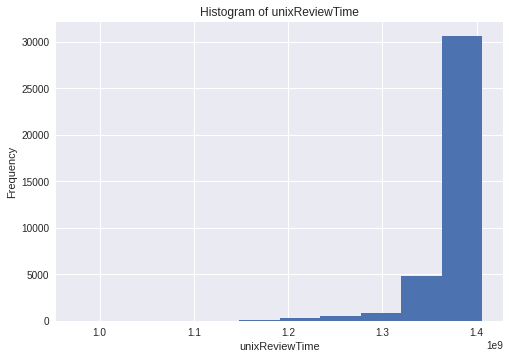

In [8]:
plt.hist(instant_video['unixReviewTime'])
plt.xlabel('unixReviewTime')
plt.ylabel('Frequency')
plt.title('Histogram of unixReviewTime');

2. For the `movies_tv` dataset

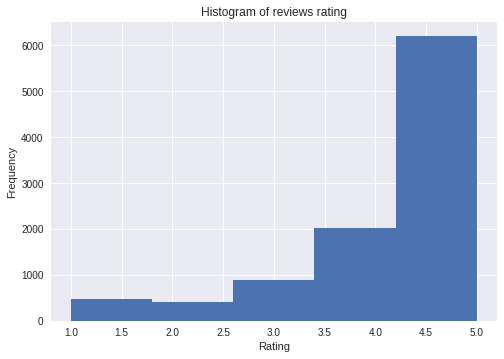

In [9]:
plt.hist(movies_tv['overall'],bins=5)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of reviews rating');

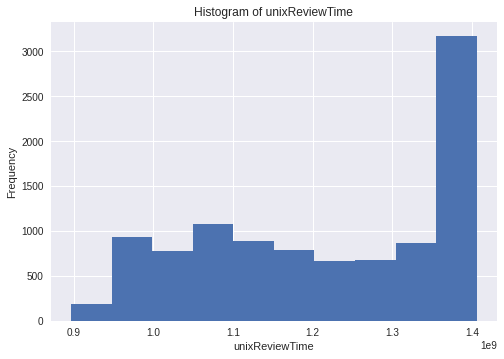

In [10]:
plt.hist(movies_tv['unixReviewTime'])
plt.xlabel('unixReviewTime')
plt.ylabel('Frequency')
plt.title('Histogram of unixReviewTime');

We could see that for both datasets the distribution of the review rating (`overall`) is quite similar, being the good reviews overwhelmingly higher than the bad reviews (4,5 vs. 1,2). Where the two sets differ is in `unixReviewTime`. We can see that for `instant_video` the vast majority of reviews where done in the last years, mainly 2014, whilst in the `movies_tv` we also see an uprise in 2014, but a more homogeneous distribution on previous years.

-------

#### 1.2

How do average ratings change over time? Plot the average rating for each year and note any trends.

**Answer.**

In [11]:
instant_video['year'] = instant_video['datetime'].dt.year
movies_tv['year'] = movies_tv['datetime'].dt.year

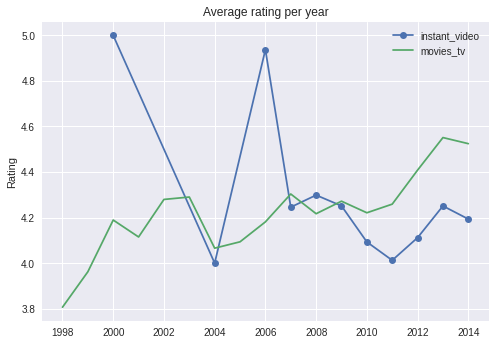

In [12]:
plt.plot(instant_video.groupby('year')['overall'].mean(),marker='o',label='instant_video')
plt.plot(movies_tv.groupby('year')['overall'].mean(),marker='',label='movies_tv')
plt.title('Average rating per year')
plt.ylabel('Rating')
plt.legend();

For the `movies_tv` dataset we could see a clear trend towards better reviewing ratings. On the other hand, we could not say much about the `instant_video` dataset. This one exhibits two high values on 2000 and 2006, but since 2007 it is mostly between 4 and 4.2. 

-------

#### 1.3

Look at the average length of the review by year. Do you notice any trends?

<AxesSubplot:xlabel='datetime'>

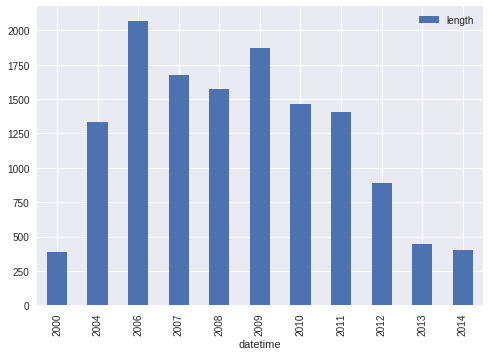

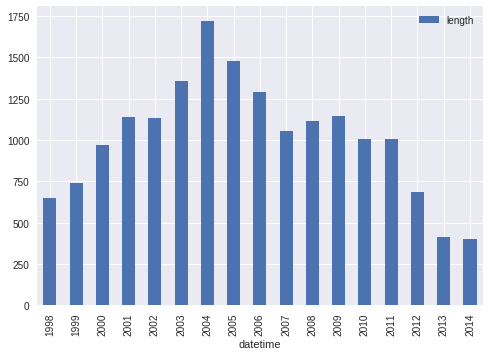

In [13]:
instant_video['length'] = instant_video['reviewText'].apply(len)
instant_video.groupby(instant_video.datetime.dt.year)['length'].mean().to_frame().plot(kind="bar")

movies_tv['length'] = movies_tv['reviewText'].apply(len)
movies_tv.groupby(movies_tv.datetime.dt.year)['length'].mean().to_frame().plot(kind="bar")

**Answer.**

We could clearly see that there is a downward trend in the length of reviews for both datasets. More interesting is the fact that during 2014 reviews exhibit one of the lowest values of review lengths.

-------

### Exercise 2:

#### 2.1

Find the ten most frequently occuring non-stop words acrooss: (i) all reviews, (ii) positive reviews, (iii) negative reviews. Do the results surprise you? Why or why not?

**Answer.**

First of all, we begin by loading the stopwords in order to avoid counting them in our reviews:

In [14]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Secondly, as seen in case_5.3, we could define a function that returns the most common non-stop words:

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=1,k=1):
    vec = CountVectorizer(ngram_range=(k,k),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

Finally, we define what we're going to understand as a positive/negative review. The former is the subset of data that has an `overall` of 4 and 5, while the latter is the subset that exhibits an `overall` of 1 and 2. Of course, all reviews would include an `overall` of 3 along with the positive and negative values.

1. All reviews:

In [16]:
common_words = get_top_n_words(instant_video['reviewText'],10,1)
for word, freq in common_words:
    print(word, freq)

season 16885
like 14748
series 12901
good 12663
just 11465
great 10594
34 10184
really 9097
love 8989
watch 8989


In [17]:
common_words = get_top_n_words(movies_tv['reviewText'],10,1)
for word, freq in common_words:
    print(word, freq)

movie 13464
film 10666
like 4838
great 4329
good 4238
quot 4106
just 4046
story 3686
time 3612
really 2877


2. Positive reviews:

In [18]:
common_words = get_top_n_words(instant_video[instant_video['overall'].isin([4,5])]['reviewText'],10,1)
for word, freq in common_words:
    print(word, freq)

season 14255
series 10914
like 10206
good 9692
great 9375
love 8003
just 7342
34 7138
watch 6912
characters 6685


In [19]:
common_words = get_top_n_words(movies_tv[movies_tv['overall'].isin([4,5])]['reviewText'],10,1)
for word, freq in common_words:
    print(word, freq)

movie 10740
film 8445
great 3871
like 3653
quot 3331
good 3311
just 3022
story 3016
time 2986
love 2470


3. Negative reviews:

In [20]:
common_words = get_top_n_words(instant_video[instant_video['overall'].isin([1,2])]['reviewText'],10,1)
for word, freq in common_words:
    print(word, freq)

just 2198
like 2123
movie 1784
34 1412
film 1206
really 1176
good 1148
don 1021
time 1002
people 958


In [21]:
common_words = get_top_n_words(movies_tv[movies_tv['overall'].isin([1,2])]['reviewText'],10,1)
for word, freq in common_words:
    print(word, freq)

movie 1390
film 1089
like 592
just 499
jesus 469
quot 393
good 346
really 302
story 299
people 298


The results have similar words between the three cases evaluated. For example, the words **like** and **good** are common in positive or negative reviews. This is not entirely surprising since we're not controlling for the context.

-------

 #### 2.2

Find words that are indicative of bad reviews. That is, words that appear often in bad reviews and *not* in good reviews. What are these words and are they surprising?

**Answer.**

In [22]:
pos_words = get_top_n_words(instant_video[instant_video['overall'].isin([4,5])]['reviewText'],10,1)
neg_words = get_top_n_words(instant_video[instant_video['overall'].isin([1,2])]['reviewText'],10,1)
set(pd.DataFrame(neg_words)[0]) - set(pd.DataFrame(pos_words)[0])

{'don', 'film', 'movie', 'people', 'really', 'time'}

In [23]:
pos_words = get_top_n_words(movies_tv[movies_tv['overall'].isin([4,5])]['reviewText'],10,1)
neg_words = get_top_n_words(movies_tv[movies_tv['overall'].isin([1,2])]['reviewText'],10,1)
set(pd.DataFrame(neg_words)[0]) - set(pd.DataFrame(pos_words)[0])

{'jesus', 'people', 'really'}

Continuing with the previous exercise, taking into account only the top 10 words on each of the cases, we could see that the words doesn't are very meaningful in determining the reasons why the negative reviews could really be negative.

-------

### Exercise 3:

Manually inspect the first 10 negative reviews containing the word "good". What do you notice? How does this suggest we ought to proceed next?

**Answer.**

In [24]:
reviews_containing_good = [each for each in instant_video[instant_video['overall'].isin([1,2])]['reviewText'] if 'good' in each] + [each for each in movies_tv[movies_tv['overall'].isin([1,2])]['reviewText'] if 'good' in each]
reviews_containing_good[0:9]

['I watched this because the Brits usually do a good job with good production values, casting and story lines.  However, in this case it proved a waste of 5 hours. The writers, directors and editors should be ashamed to put their names in the credits.  Important things happen with no apparent reason and the watcher is left scratching his/her head wondering what was the point.  The American general is miscast and not believable.  Lots of clicking of computer keyboards for solutions that never seem to work out. The ending stinks!',
 "You know the plot. Trashy kids being trashy. The &#34;good&#34; ones are the &#34;poor&#34; ones. The rich trashy kids are just &#34;bad&#34;. Another movie to help the retarded careers of this TV show's actors. They are all old and washed out. But they still try to be hip and cool with their texting and foul mouths, sex videos. Sorry if you can't route for the heroine of the movie it clearly isn't worth watching.",
 "There's a scene in Misery where the auth

There is a lot of information when we filter the negative reviews that contains the word "good". In fact, there is so much information that it turns out to be uninformative. For this reason we should try to find some context, but just extracting some of the words surrounding "good".

-------

### Exercise 4:

Go through the list of bad reviews containing the word "good" that we found in the last question. For each review, extract the following:

1. The first word after "good"
2. The first word after "good" that is a noun or cardinal
3. The last word before "good" that is a noun or cardinal

**Answer.**

To answer some of this questions it is useful to use the regular expressions module, so we begin loading it and defining a function that let us extract what we're asked for, similar to what we've seen in case_5.3:

1. First word after good:

In [25]:
import re

In [26]:
def next_word(sentence):
    post = re.findall(r'good.*', sentence)
    if (len(post) > 0):
        temp = re.split(r'\s',post[0])
        if (len(temp) > 1):
            return(temp[1])
        else:
            return('')
    else:
        return('')

In [27]:
post_good = []
ind = 0
for sentence in reviews_containing_good:
    temp = next_word(sentence)
    post_good.append(temp)
    
nonempty = [i for i in post_good if i] 
print(nonempty)

['job', 'ones', 'movie.', 'for', 'TV.', 'but', 'Guess', 'acting', 'actors,', 'mystery!Dani', 'stories,', 'portrayal', 'as', 'Until,', 'one', 'roles', 'for', 'things', 'for', 'example', 'about', 'time,', 'thing', 'and', 'comic', 'Bikers', 'caper', '--', 'nor', 'actress', 'citizen', 'for', 'intentions', 'job', 'and', 'purpose.', 'thing', 'show!Oh', 'people', 'in', 'movie', 'story', 'Battle', 'but', 'guys"', 'funny', 'The', 'job', 'at', 'episodes', 'stuff', 'guys', 'thing', 'story-telling', 'at', 'Just', 'at', 'they', 'but', 'psychic', 'A', 'quality-wise,', 'guy', 'horror', 'job', 'I', 'for', 'but', 'if', 'but', 'part', 'luck', 'stream', 'character.', 'guy&#34;,', 'story?So', 'fortune', 'Elijah', 'and', 'but', 'to', 'premise', 'administrator.', 'Roman', 'choreography', 'given', 'show', 'but', 'looking', 'to', 'thing,', 'direction', 'TV.', 'effects', 'picture', 'things', 'book.', 'old', 'satire,', 'Scoot', 'cinematography', 'creature', 'but', 'to', 'happens', 'cop', 'people,', 'characters.

2. First word after "good" that is a noun or cardinal:

In [28]:
[lis[0] for lis in nltk.pos_tag(nonempty) if lis[1] == 'CD' or lis[1] == 'NN']

['job',
 'movie.',
 'actors,',
 'mystery!Dani',
 'stories,',
 'portrayal',
 'one',
 'example',
 'thing',
 'caper',
 'citizen',
 'job',
 'thing',
 'show!Oh',
 'movie',
 'story',
 'job',
 'thing',
 'story-telling',
 'guy',
 'horror',
 'job',
 'part',
 'stream',
 'character.',
 'guy&#34;,',
 'story?So',
 'fortune',
 'choreography',
 'show',
 'direction',
 'cinematography',
 'creature',
 'people,',
 'characters.',
 'amount',
 'idea',
 'voice',
 'thing',
 'job.',
 'either.',
 'show...',
 'rating.',
 'photography.',
 'cinema.',
 'light',
 'premise,',
 'show',
 'manners,',
 'story.',
 'movie',
 'presentation',
 'thing',
 'executive,',
 'show',
 'though.',
 'reviews)',
 'job',
 'idea.',
 'horror',
 'thing.',
 'thing',
 'idea',
 'use',
 'thing',
 'effort.',
 'acting',
 'film',
 'tree',
 'toss,',
 '1h',
 'concept?!?!',
 'show',
 '1/3',
 'grades,',
 'value',
 '`found',
 'episode',
 'way',
 'movie',
 "job.It's",
 'showes?',
 'story',
 'performance.',
 'thing',
 'idea,',
 'pic,',
 'choice.',
 'anth

3. Last word before "good" that is a noun or cardinal:

In [29]:
def next_word(sentence):
    post = re.findall(r'.*good', sentence)
    if (len(post) > 0):
        temp = re.split(r'\s',post[0])
        if (len(temp) > 1):
            return(temp[1])
        else:
            return('')
    else:
        return('')

In [30]:
post_good = []
ind = 0
for sentence in reviews_containing_good:
    temp = next_word(sentence)
    post_good.append(temp)
    
nonempty = [i for i in post_good if i]

In [31]:
[lis[0] for lis in nltk.pos_tag(nonempty) if lis[1] == 'CD' or lis[1] == 'NN']

['waste',
 'reboot',
 'story',
 '4',
 'series',
 'show',
 'show',
 'outta',
 'guess',
 'one',
 'daughter',
 'review',
 'one',
 'story',
 'thought',
 'pedestrian.',
 'review',
 'story',
 'watch',
 'episode',
 'movie',
 'characters,',
 'egg',
 'movie',
 'show',
 'concept',
 '1',
 'see',
 'movie',
 "hasn't",
 'director',
 'movie',
 'cynocephalus',
 'kind',
 'movie',
 'movie',
 'movie',
 'understand',
 'series',
 '407',
 'show',
 'budget',
 '(Michelle',
 'kung',
 'hand',
 'let',
 'love',
 'show.',
 'have',
 'attempt',
 'okay',
 'one',
 'one',
 'film',
 'love',
 'think',
 'knew',
 'one',
 "don't",
 'show',
 'show',
 'film',
 'show',
 'premise',
 'line',
 'special',
 'watch',
 'opportunity',
 'show',
 'nothing',
 "didn't",
 'premise,',
 'feel',
 'sorry',
 'disappointment.',
 'sat',
 'love',
 'quit',
 'upon',
 'movie',
 'action',
 'lot',
 'town',
 'second',
 'caught',
 'weak!',
 '1980',
 '(Franck',
 'movie',
 'movie',
 'show',
 'movie',
 'game',
 'thing',
 'one',
 'waste',
 'preview',
 'show'

-------

### Exercise 5:

We have seen that individual words are not always very informative. Look for the most informative bigrams and trigrams, in both positive and negative reviews. Show the most informative bigrams and trigrams and give a brief analysis of the n-grams you identified.

**Answer.**

Following the same approach as before, we're going to retrieve only the top 10 most common bigrams and trigrams:

- Positive bigrams:

In [32]:
get_top_n_words(instant_video[instant_video['overall'].isin([4,5])]['reviewText'],10,2)

[('story line', 944),
 ('second season', 643),
 ('sci fi', 588),
 ('story lines', 566),
 ('ve seen', 564),
 ('looking forward', 539),
 ('highly recommend', 538),
 ('worth watching', 503),
 ('fun watch', 483),
 ('amazon prime', 480)]

- Positive trigrams:

In [33]:
get_top_n_words(instant_video[instant_video['overall'].isin([4,5])]['reviewText'],10,3)

[('looking forward season', 164),
 ('keeps getting better', 106),
 ('great story line', 98),
 ('love love love', 92),
 ('does great job', 92),
 ('good story line', 88),
 ('just keeps getting', 83),
 ('gets better better', 82),
 ('amazon instant video', 80),
 ('did great job', 77)]

- Negative bigrams:

In [34]:
get_top_n_words(instant_video[instant_video['overall'].isin([1,2])]['reviewText'],10,2)

[('waste time', 150),
 ('story line', 116),
 ('ve seen', 114),
 ('don know', 102),
 ('sci fi', 92),
 ('don think', 81),
 ('34 34', 79),
 ('looks like', 75),
 ('high school', 64),
 ('special effects', 63)]

- Negative trigrams:

In [35]:
get_top_n_words(instant_video[instant_video['overall'].isin([1,2])]['reviewText'],10,3)

[('don waste time', 43),
 ('really wanted like', 24),
 ('parental guide bomb', 14),
 ('big bang theory', 13),
 ('waste time money', 12),
 ('bad acting bad', 12),
 ('don waste money', 10),
 ('dvd distribution handled', 10),
 ('note following review', 10),
 ('following review contain', 10)]

The previous analysis let us identify that the trigrams captures more significant positive or negative words than the bigrams. Almost all of the trigrams are really describing a positive/negative situation, while the bigrams still leaves some of those words as uninformative.

-------

### Exercise 6:

Throughout the above search for informative words, we have seen that unigrams are not enough, but important words (such as "good") are not always next to the informative words that they describe. Devise a method to extract these informative words. Provide a brief description of how you will extract the informative words.

**Answer.**

I think that the most important piece of information when giving an opinion about the quality of something, in this context movies and tv series, are words that describes what our thoughts on the issue are: that is, **adjectives**. Also, as we have seen on the previous exercises, the trigrams could be quite useful when analyzing sentences because they give a little bit more of context that an entire passage.

In this sense, I think that a method to extract informative words could be to begin extracting **adjectives** from **trigrams** for positive and negative words, and then filtering meaningful words from those lists. In this case, we could define a word as meaningful if it exists *only* in positive reviews, but not in negative reviews.

As we have seen, the word "good" could be used on positive and negative reviews, however, a word like 'awful' would certainly not be used on a positive review, but in a negative.  

-------

### Exercise 7:

Write a function(s) that transforms a sentence into a new text list by iteratively pairing each adjective in the sentence with the next noun that follows it in the sentence. For example, the text "That was a good, long movie" should return `["good movie", "long movie"]`.

**Answer.**

In [73]:
def list_adj_noun(sentence):
    """
    This function takes a sentence as an input and prints a list
    containing an iteration between adjectives and its next nearer noun.
    
    Arguments: a sentence defined a a str
    
    Outputs: a list of interest with the pairs of adjectives and nouns of a sentence.
    """
    #Define the elements that returns the function:
    list_interest = []
    
    #Extract the words and identify the adjectives:
    words    = nltk.word_tokenize(sentence)
    adject   = [k for k,v in nltk.pos_tag(words) if v in ['JJ']]
    
    #Begin a for loop for each of the adjectives to found its nearest noun:
    for a in adject:
        pos_ad       = words.index(a)
        remain_words = words[pos_ad:len(words)]
        next_nouns   = [k for k,v in nltk.pos_tag(remain_words) if v in ['NN']]
        if(len(next_nouns) > 0):
            list_interest.append([a,next_nouns[0]])
        else:
            list_interest.append([a,''])
                              
    return list_interest

In [74]:
sentence = "That was a good, long beautiful movie"
list_adj_noun(sentence)

[['good', 'movie'], ['long', 'movie'], ['beautiful', 'movie']]

-------